In [3]:
import cupy
import cupyx
import numpy as np
from matplotlib import pyplot as plt
import os
from FastMediumWell import gcf, corrfun

cupy.cuda.Device().synchronize()
cupy._default_memory_pool.free_all_blocks()
# auto reload 
%load_ext autoreload
%autoreload 2

In [2]:
datanpz = np.load('data/uvw_stokesI.npz')

# uvw = uvw, scan=scan, flag_I=flag_I, stokes_I=stokes_I
uvw = datanpz['uvw']
scan = datanpz['scan']
flag_I = datanpz['flag_I']
stokes_I = datanpz['stokes_I']

In [3]:
src = 'src/funcGridding.cu'
dir_src = os.path.dirname(os.path.realpath(src))

griddingFuncSrc = open(src, 'rt')
griddingSimple = cupy.RawModule(code=griddingFuncSrc.read(), backend='nvcc',options=("-I "+dir_src,))
griddingFun = griddingSimple.get_function("SimpleGridding")
griddingFunBatch = griddingSimple.get_function("SimpleGriddingBatch")

In [4]:
process_idx = 1
# how many scan
scan_unique = np.unique(scan)
#for this_scan in scan_unique:
#    ind = np.where(scan == this_scan)[0]
    #plt.plot(uvw[0,ind], uvw[1,ind], 'o')
ind = np.where(scan == process_idx)[0]

uvw_this_scan = uvw[:,ind]
stokes_I_this_scan = stokes_I[ind]

u_inp = uvw_this_scan[0,:]
v_inp = uvw_this_scan[1,:]

I_real = stokes_I_this_scan.real
I_imag = stokes_I_this_scan.imag

image_size = 300
cell =  50 # asec

nx = np.int32(2*image_size)
n_offset = np.int32((nx-image_size)/2)
arc2rad = np.float32(np.pi / 180. / 3600.)

umax = np.max(np.abs(u_inp))
vmax = np.max(np.abs(v_inp))
du = np.float32(1. / (arc2rad * cell)) / (image_size * 2.)
n_umax = np.int32(np.ceil(umax / du))
n_vmax = np.int32(np.ceil(vmax / du))

In [5]:
uvw[:,0+5]  - uvw[:,1176*90+5]

array([-0.02199737, -0.0058088 ,  0.01978758])

In [6]:
vmax

470.45792218312124

In [7]:
gcount = u_inp.shape[0]

/tmp/ipykernel_2665207/383639891.py:8: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.abs(convGridFuncTab)), 'o')


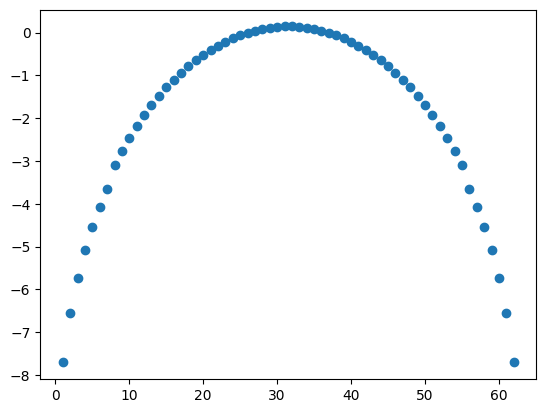

In [8]:
from FastMediumWell import gcf


WIDTH= 7
NCGF= 64
HWIDTH= 4
convGridFuncTab = gcf(NCGF, WIDTH)
plt.plot(np.log(np.abs(convGridFuncTab)), 'o')



# Schwab 1984

In [9]:
blocksize_2D = (8, 16, 1)
gridsize_2D = (np.int32(np.ceil(1. * nx / blocksize_2D[0])),1)
batch_img = np.int32(np.ceil(1. * nx / blocksize_2D[1]))



In [10]:
d_grd = cupy.zeros((np.int32(nx), np.int32(nx)), np.complex64)
d_ngrd = cupy.zeros_like(d_grd)
d_bm = cupy.zeros_like(d_grd)
d_nbm = cupy.zeros_like(d_grd)
d_cbm = cupy.zeros_like(d_grd)

d_u = cupy.asarray(u_inp, dtype=cupy.float32)
d_v = cupy.asarray(v_inp, dtype=cupy.float32)
d_re = cupy.asarray(I_real, dtype=cupy.float32)
d_im = cupy.asarray(I_imag, dtype=cupy.float32)
d_cnt = cupy.zeros_like(d_grd, dtype=cupy.int32)

d_gcf = cupy.asarray(convGridFuncTab, dtype=cupy.float32)

du = cupy.float32(du)

In [11]:
blocksize_2D

(8, 16, 1)

In [12]:
for n in range(1):
    griddingFun(gridsize_2D, blocksize_2D,
               (d_grd,d_bm, d_cbm, d_cnt, d_u, d_v, d_re, d_im,
                d_gcf, WIDTH,  HWIDTH, NCGF, nx, du, gcount, n_umax, n_vmax, batch_img))
# synchronize
cupy.cuda.Device().synchronize()

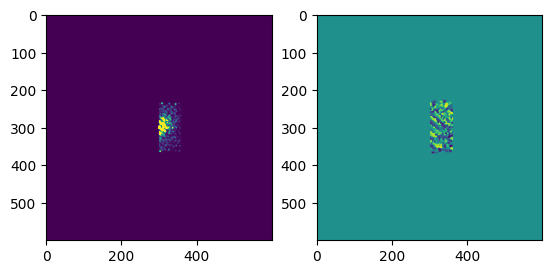

In [13]:
ax1 = plt.subplot(121)
ax1.imshow((np.abs(d_grd.get())),vmax=5e5)
ax2 = plt.subplot(122)
ax2.imshow((np.angle(d_grd.get())))

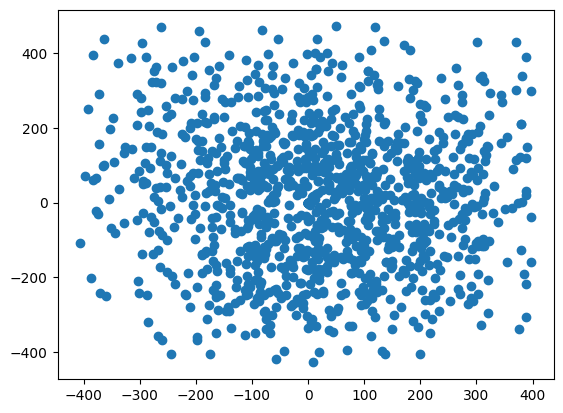

In [14]:
plt.plot(u_inp, v_inp, 'o')

In [15]:
u_inp.shape

(1176,)

In [16]:
import sys
sys.getsizeof(d_grd.get())/8/1024/1024 # MB  per 256*256 complex64

0.3433380126953125

In [17]:
batch_vis = 100


In [18]:
d_grd    = cupy.zeros((np.int32(nx), np.int32(nx)), np.complex64)
d_grd_3d = cupy.zeros((batch_vis, np.int32(nx), np.int32(nx)), np.complex64)

d_ngrd = cupy.zeros_like(d_grd)
d_bm = cupy.zeros_like(d_grd)
d_nbm = cupy.zeros_like(d_grd)
d_cbm = cupy.zeros_like(d_grd)
d_cnt = cupy.zeros_like(d_grd, dtype=cupy.int32)

d_u = cupy.asarray(u_inp, dtype=cupy.float32)
d_v = cupy.asarray(v_inp, dtype=cupy.float32)
d_gcf = cupy.asarray(convGridFuncTab, dtype=cupy.float32)
cupy.cuda.Device().synchronize()

In [19]:
stokes_I_reorder = stokes_I # stokes_I.reshape(100,1176).T.flatten()
d_re_2d = cupy.asarray(stokes_I_reorder.real, dtype=cupy.float32)
d_im_2d = cupy.asarray(stokes_I_reorder.imag, dtype=cupy.float32)

In [20]:
gcount_total=d_re_2d.shape[0]

In [21]:
src = 'src/funcGridding.cu'
dir_src = os.path.dirname(os.path.realpath(src))

griddingFuncSrc = open(src, 'rt')
griddingSimple = cupy.RawModule(code=griddingFuncSrc.read(), backend='nvcc',options=("-I "+dir_src,))
SimpleGridding = griddingSimple.get_function("SimpleGridding")
SimpleGriddingBatch = griddingSimple.get_function("SimpleGriddingBatch")

In [22]:
batch_vis
d_flag = cupy.asarray(flag_I, dtype=cupy.float32)

d_grd_3d[50,nx//2,nx//2]

array(0.+0.j, dtype=complex64)

In [23]:

SimpleGriddingBatch(gridsize_2D, blocksize_2D,
                (d_grd_3d, d_flag,
                d_bm, d_cbm, d_cnt, d_u, d_v, d_re_2d, d_im_2d,
                d_gcf, WIDTH,  HWIDTH, NCGF, nx, du, gcount, gcount_total,
                n_umax, n_vmax, batch_img, batch_vis))
cupy.cuda.Device().synchronize()


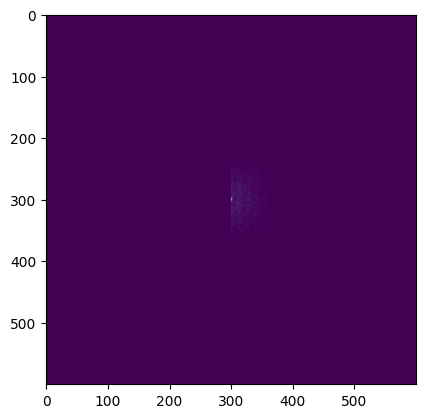

In [24]:
plt.imshow(d_bm.get().real)

In [25]:
new_d_grd_3d = cupy.zeros_like(d_grd_3d)
new_d_grd_3d[:,:,:] = d_grd_3d[:,:,:]

new_d_grd_3d[:,:,0:np.int32(nx/2)]=cupy.flip(
    cupy.flip(cupy.conjugate(d_grd_3d),axis=1),
    axis=2)[:,:,0:np.int32(nx/2)]

d_bm[:,0:np.int32(nx/2)]=cupy.flip(
    cupy.flip(cupy.conjugate(d_bm),axis=0),
    axis=1)[:,0:np.int32(nx/2)]

In [26]:
import cupy.fft as cufft

corr_beam = cufft.ifftshift(cupy.real(cufft.ifft2(cufft.fftshift(d_bm))))

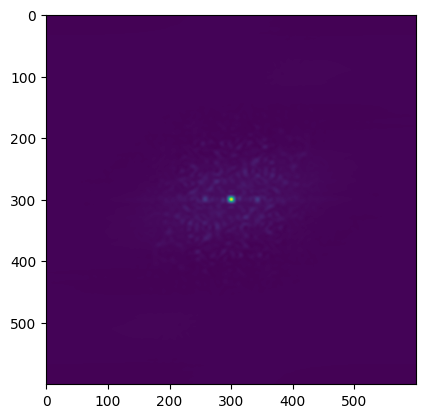

In [27]:
plt.imshow(corr_beam.get().real)

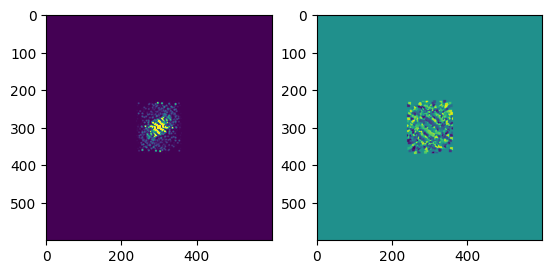

In [28]:
ax1 = plt.subplot(121)
ax1.imshow((np.abs(new_d_grd_3d[0,:,:].get())),vmax=5e5)
ax2 = plt.subplot(122)
ax2.imshow((np.angle(new_d_grd_3d[0,:,:].get())))

In [29]:
mask_center  = cupy.ones_like(d_grd_3d[0,:,:],dtype=cupy.float32)
xx,yy = cupy.meshgrid(cupy.arange(nx),cupy.arange(nx))
mask_center[cupy.sqrt((xx-nx/2)**2 + (yy-nx/2)**2) < 7] = 0

In [30]:
d_corr = corrfun(nx, WIDTH)
corr2d  = cupy.max(d_corr)**2/ ( cupy.tile(d_corr,(nx,1)) * cupy.tile(d_corr,(nx,1)).T )


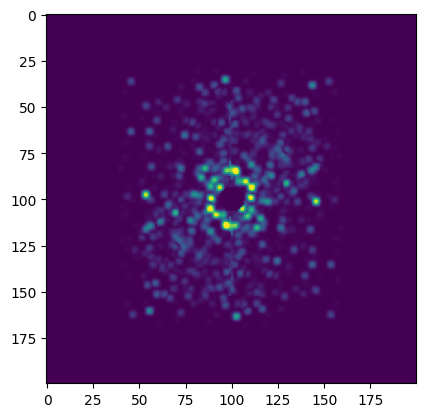

In [31]:
import cupy as cp
from cupyx.scipy.fft import get_fft_plan
import cupyx.scipy.fft

for i in range(100):
    new_d_grd_3d[i,:,:] = new_d_grd_3d[i,:,:]*mask_center*corr2d

plt.imshow(np.abs(new_d_grd_3d[9,(nx//2-100):(nx//2+100),(nx//2-100):(nx//2+100)]).get(),vmax=1e6)

In [32]:
# fftshift before fft

#new_d_grd_3d = cupy.fft.fftshift(new_d_grd_3d, axes=(1, 2))
#plan = get_fft_plan(new_d_grd_3d, axes=(1, 2), value_type='C2C')
#out = cupy.fft.fftshift(cupyx.scipy.fft.ifft2(new_d_grd_3d, plan=plan))
from cupy import fft as cufft

out = cufft.ifftshift(cupy.real(cufft.ifft2(cufft.fftshift(new_d_grd_3d, axes=(1,2)),axes=(1,2))),axes=(1,2))

h_corr = corrfun( nx, WIDTH)
corr_arr = (np.tile(h_corr,[nx,1]))*(np.tile(h_corr,[nx,1])).T
corr_arr = np.max(corr_arr)/corr_arr

for idx in range(out.shape[0]):
    out[idx,:,:]*=cupy.array(corr_arr)

In [33]:
real_image=out
real_image = out[:,np.int32(nx*0.25):np.int32(nx*0.75),
                 np.int32(nx*0.25):np.int32(nx*0.75)]


In [34]:
# fftshift before fft
#new_d_grd_3d_shift = cupy.fft.ifftshift(new_d_grd_3d, axes=(1, 2))
#plan = get_fft_plan(new_d_grd_3d_shift, axes=(1, 2), value_type='C2C')
#for n in range(1):
#    out2 = cupyx.scipy.fft.ifft2(new_d_grd_3d_shift, axes=(1, 2), plan=plan)

#rawfftimg = cufft.fftshift(cupy.real(out2[1,:,:,])).get()
#plt.imshow(rawfftimg,vmin=0)


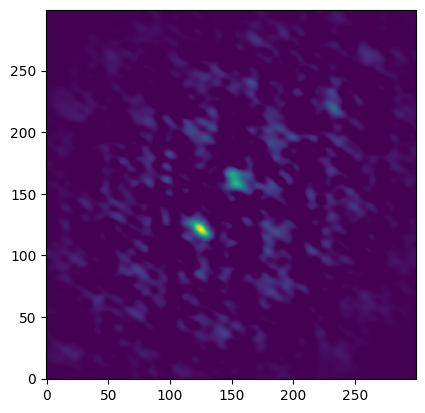

In [39]:
plt.imshow(np.flipud((np.real(real_image[2,:,:].get().squeeze()))),
           origin='lower', vmin=0)
#plt.xlim(256-128,(128+256))
#plt.ylim(256-128,(128+256))


In [36]:
np.max(real_image[13,:,:])

array(1387.6393, dtype=float32)

In [37]:
grided_data_cpu = new_d_grd_3d[2,:,:].get()

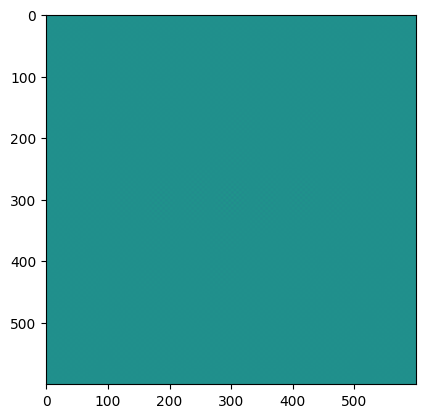

In [178]:
plt.imshow(np.fft.fftshift(np.real(np.fft.ifft2(grided_data_cpu))))

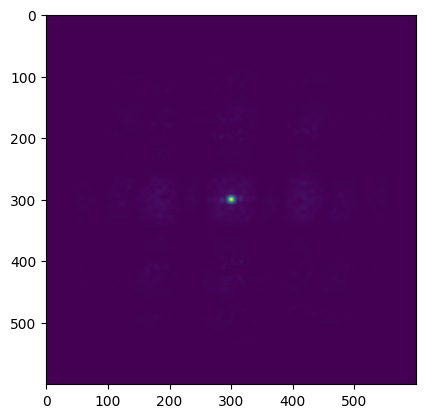

In [179]:
plt.imshow(np.fft.fftshift(np.abs(cupy.fft.fft2((d_bm)).get())))

In [71]:
# the size of the image in MB
sys.getsizeof(new_d_grd_3d.get())/8/1024/1024

100.0000171661377

In [72]:
#todo: fft c2r

# do not show plot in this notebook
plt.ioff()

from astropy.io import fits
for idx in range(100):
    fig = plt.figure(figsize=(8,4),dpi=130
                     )
    ax1 = fig.add_subplot(121)
    fname_dirty = 'sun_only-t'+str(idx).rjust(4,'0')+'-dirty.fits'
    hdul = fits.open(fname_dirty)
    data_dirty = hdul[0].data.squeeze()
    ax1.imshow(data_dirty, origin='lower',vmin=0)
    ax1.set_title('wsclean')

    ax2 = fig.add_subplot(122)
    ax2.imshow(np.flipud((np.real(real_image[idx,:,:].get().squeeze()))),origin='lower',vmin=0)
    ax2.set_title('gpu imager')
    fig.savefig('fig/gpu_imager_'+str(idx).rjust(4,'0')+'.png')
    plt.close('all')
   

In [ ]:
#ffmpeg -framerate 30 -pattern_type glob -i '*.jpg' \
#  -c:v libx264 -pix_fmt yuv420p out.mp4

In [4]:
a = [0.006807021414715564,
0.0012232652893544582,
0.0011433831041358644,
0.0011419994775678788,
0.0011191266489731788,
0.0011032805132344947,
0.0011257775336162013,
0.0011151227217851556,
0.001101287530218542,
 0.0011007111856997653,
 0.0011091846231465752,
 0.001113833818180865,
 0.0011016408902833064,
 0.0010971459705615416,
 0.0011029944876099762,
 0.0010980455090248142,
 0.0011038653806281218,
 0.001098795480629633,
 0.0011114313588223013,
 0.0010933674602711108,
 0.00110301700533455,
 0.0011041468942494248,
 0.001083897932403488,
 0.0010997318354384333,
 0.0010980180163642217,
 0.001088600990442501,
 0.0010985147960127506,
 0.0010805533720485982,
 0.001088408380837791,
 0.0010726559635259036,
 0.0009630159270272998,
 0.0008023619520827197,
 0.0006399744186182943,
 0.0005112858787015284,
 0.00043560771928241593,
 0.0003817096353486704,
 0.00034205049314550706,
 0.0003240635908241529,
 0.00029719005090100836,
 0.000285970683648884,
 0.0002704167856109052,
 0.0002651447168773302,
 0.0002540506839068257,
 0.00023723785557194788,
 0.00023309526204684516,
 0.00022919406671917386,
 0.00022785564146943216,
 0.00021438738076540176,
 0.00020912065997436002,
 0.00020316743348303135,
 0.00020293126624437718,
 0.0001937915212693042,
 0.0001900627216855355,
 0.00018422618995828088,
 0.00018135300672383892,
 0.00018284028863035928,
 0.00017872182343126042,
 0.0001750112286345029,
 0.0001687490998847352,
 0.00017317029573860054,
 0.00016698821696081723,
 0.00016971714683222672,
 0.00016534331405182456,
 0.0001617168799157298,
 0.0001587296791853987,
 0.00015898741105502268,
 0.0001583373796165688,
 0.00015718685790488962,
 0.0001528857925450211,
 0.00015224166077132395,
 0.00014936489156980315,
 0.00013909012528756648,
 0.00014116854589474315,
 0.00014251503233708718,
 0.00013855508575488784,
 0.0001413281275972622,
 0.00014021483855231054,
 0.00013587148180249642,
 0.00013201754057945436,
 0.00013509503742170637,
 0.00013007141194520955,
 0.0001293725687787628,
 0.00013145385980806168,
 0.00012587020631826817,
 0.00012390687999186412,
 0.00012268793608427586,
 0.00012354065694353267,
 0.00012202490574964031,
 0.00011842899084513192,
 0.00011886458810295153,
 0.000113113713553048,
 0.00011256230010303625,
 0.00011262325887173574,
 0.00011096755434891747,
 0.00011021881471151573,
 0.00011067126649777492,
 0.00010805075555708754,
 0.0001087787534288509,
 0.0001073726897971028,
  0.00010502639736387209,
  0.0001050594115667991,
  0.00010569923466619002,
  0.00010272583966752791,
  0.00010301531222012272,
  0.00010330236068512022,
  9.889208246249837e-05,
  0.00010274325018144737,
  9.946383511305612e-05,
  9.556818952205504e-05,
  9.95082077679399e-05,
  9.38947773079235e-05,
  9.545612846295626e-05,
  9.393094683218806e-05,
  9.416623800007073e-05,
  9.369919388291237e-05,
  9.47230245742503e-05,
  8.952313231702647e-05,
  9.250602988686296e-05,
  9.163050100369219e-05,
  9.134411851619006e-05,
  8.85738666056568e-05,
  9.192449539341396e-05,
  8.758924860785555e-05,
  8.864793926477432e-05,
  8.89965829742323e-05,
  8.568494763494527e-05,
  8.619675844556696e-05,
  8.689443541243236e-05,
  8.71205683097287e-05,
  8.48601720804254e-05,
  8.326824041660075e-05,
  8.35680008322015e-05,
  8.366432922457534e-05,
  8.26372296955924e-05,
  8.244800687862153e-05,
  8.13802046195633e-05,
  8.40933124663934e-05,
  8.345649376906294e-05,
  8.229216388144778e-05,
  8.07766920161157e-05,
  7.712193121278688e-05,
  7.795561623424874e-05,
  7.993642898895814e-05,
  7.573073807520814e-05,
  7.766927174657212e-05,
  7.719728975530415e-05,
  7.884322707241154e-05,
  7.483605713787256e-05,
  7.43400865417243e-05,
  7.62330422787727e-05,
  7.602122497019081e-05,
  7.63864589998775e-05,
  7.646945380201942e-05,
  7.514109120165813e-05,
  7.365823756799728e-05,
  7.43481006395541e-05,
  7.295735224488453e-05,
  7.402357766750356e-05,
  7.169948290197681e-05,
  7.294621127584833e-05,
  7.316831613479735e-05,
  7.46371623279174e-05,
  7.368675431962401e-05,
  7.005346759569875e-05,
  7.193400668370487e-05,
  6.915547689345658e-05,
  7.142082179711906e-05,
  6.856235603436289e-05,
  7.020269933377676e-05,
  6.997976325351374e-05,
  6.944781202378181e-05,
  6.817296781491677e-05,
  6.851208775060513e-05,
  6.955788393270268e-05,
  6.717191101301978e-05,
  6.896842779724466e-05,
  6.651877305330345e-05,
  6.715169780591168e-05,
  6.745459015178312e-05,
  6.706210962192927e-05,
  6.610142668250774e-05,
  6.767302920707152e-05,
  6.654580388953946e-05,
  6.52804046694655e-05,
  6.572076210886735e-05,
  6.826376343838092e-05,
  6.576496565458001e-05,
  6.399467781648127e-05,
  6.394650620222819e-05,
  6.614711489305591e-05,
  6.458006208731604e-05,
  6.300939270431627e-05,
  6.519536304949725e-05,
  6.478597597947555e-05,
  6.442766701297842e-05,
  6.141108141832774e-05,
  6.21750440075175e-05,
  6.600222206998296e-05,
  6.225759352673776e-05,
  6.185023656257727e-05,
  6.190986471210636e-05,
  6.241545040097662e-05,
  6.106221709956117e-05,
  6.083751071628285e-05,
  6.414627412709706e-05,
  6.284639411546777e-05,
  6.156778522381501e-05,
  6.099360464872916e-05,
  6.13113076042282e-05,
  6.104602670120585e-05,
  5.9201073696613093e-05,
  6.0523391425704176e-05,
  6.276308712926948e-05,
  6.0474923515130286e-05,
  6.0552656094614576e-05,
  5.940578958529841e-05,
  6.103058720441368e-05,
  5.928064587124027e-05,
  5.878765148281673e-05,
  5.985542853181869e-05,
  6.189418618873788e-05,
  6.050222756925905e-05,
  5.814127152348192e-05,
  5.8651806313037014e-05,
  5.67639282280652e-05,
  5.649383874128944e-05,
  5.717084954426355e-05,
  5.737300423902525e-05,
  6.215320621549836e-05,
  5.8429076489119325e-05,
  5.817647303274498e-05,
  5.6520803241255635e-05,
  5.8616578797909824e-05,
  5.786222720871592e-05,
  5.711508777039853e-05,
  5.8127681541009224e-05,
  5.705897945063043e-05,
  5.73860784243152e-05,
  5.7533063852588384e-05,
  5.5909023643607725e-05,
  5.7350077867113214e-05,
  5.809249253729831e-05,
  5.8819532370080196e-05,
  5.5687961463490865e-05,
  5.80251088138084e-05,
  5.711213131576187e-05,
  5.537100096830727e-05,
  5.584711050232727e-05,
  5.654881277905588e-05,
  5.54119374100992e-05,
  5.521519511830775e-05,
  5.729355774519718e-05,
  5.473917093468117e-05,
  5.477118708085982e-05,
  5.5570275549143844e-05,
  5.6775497654371065e-05,
  5.641030793412938e-05,
  5.501090899429073e-05,
  5.440221454477978e-05,
  5.281317081085035e-05,
  5.5547544377532176e-05,
  5.452686545481811e-05,
  5.4096082038768145e-05,
  5.3014597511946704e-05,
  5.642327374744127e-05,
  5.490465733259953e-05,
  5.343942834201698e-05,
  5.439744600721497e-05,
  5.4386110292625744e-05,
  5.406115263895117e-05,
  5.4465583758656066e-05,
  5.175285019731746e-05,
  5.254236802443302e-05,
  5.281954480551576e-05,
  5.381023748896041e-05,
  5.4014962302062486e-05,
  5.215065840502575e-05,
  5.283183818960424e-05,
  5.264116180114797e-05,
  5.3235389628980556e-05,
  5.307118541963973e-05,
  5.174402258489863e-05,
  5.424753678084926e-05,
  5.179388014653341e-05,
  5.070638437132402e-05,
  5.271138576290468e-05,
  5.309239554662781e-05,
  5.163380836847864e-05,
  5.2256284845952905e-05,
  5.115962767376914e-05,
  5.3002371402044446e-05,
  5.463550763806779e-05,
  5.059843289245691e-05,
  5.1235143473604694e-05,
  5.195710210159632e-05,
  5.090517208827805e-05,
  5.237415766146114e-05,
  5.043082376232633e-05,
  5.2606159243850925e-05,
  5.151770878342177e-05,
  5.2160610437113064e-05,
  5.1650552819637596e-05,
  5.13945893771961e-05,
  5.0228800802187834e-05,
  5.080221887965308e-05,
  5.0220745265505684e-05,
  5.105866537746806e-05,
  5.1695745440838436e-05,
  5.144506459942022e-05,
  5.0803187747305856e-05,
  5.1445159101604077e-05,
  4.9886095268902864e-05,
  5.0618844085192904e-05,
  5.1094831718501155e-05,
  5.2749733725931947e-05,
  5.281265654843992e-05,
  5.218665774009423e-05,
  4.8488320516071326e-05,
  5.1194730957604406e-05,
  4.998653116672358e-05,
  4.989360365925677e-05,
  4.9015142252528676e-05,
  5.01494801028457e-05,
  4.9130048523693404e-05,
  5.077760019389643e-05,
  5.014970409433772e-05,
  4.7856004442792255e-05,
  4.902710895748896e-05,
  4.975147493269105e-05,
  4.974605019469891e-05,
  4.877640012068696e-05,
  4.8421222260230934e-05,
  5.138877421018151e-05,
  4.838676127860708e-05,
  4.9766482675295265e-05,
  4.6968066754971005e-05,
  4.9451392214905354e-05,
  5.00487784336201e-05,
  5.01248389639386e-05,
  5.092568662234953e-05,
  4.839049375959803e-05,
  4.817288558456312e-05,
  4.728245110641183e-05,
  4.899131025126735e-05,
  4.840404244532692e-05,
  4.854056604131074e-05,
  4.995593712919799e-05,
  4.971845709178524e-05,
  4.79206480861194e-05,
  4.827596734457984e-05,
  4.888543105607823e-05,
  4.9895311917680374e-05,
  4.7864370770867026e-05,
  4.7533469654581495e-05,
  4.9289422207721145e-05,
  4.665742432052866e-05,
  4.8991293539302205e-05,
  4.654609907106533e-05,
  4.8873077645339436e-05,
  4.71990614414608e-05,
  4.797668910327957e-05,
  4.852381661635263e-05,
  4.8171240621286415e-05,
  4.7388435149287034e-05,
  4.678794707047018e-05,
  4.719520637763708e-05,
  4.749136743953386e-05,
  4.8064203411968265e-05,
  4.7803374428667667e-05,
  4.772097119598584e-05,
  4.8336650053215635e-05,
  4.719041442058369e-05,
  4.808741221040691e-05,
  4.6033855682026115e-05,
  4.740992153529078e-05,
  4.838131962969783e-05,
  4.689628460141648e-05,
  4.6695260891738144e-05,
  4.6719967883745994e-05,
  4.732457625777897e-05,
  4.791638625079031e-05,
  4.754408914209307e-05,
  4.668277176733682e-05,
  4.6534158144595494e-05,
  4.8019532698617695e-05,
  4.7000287963783194e-05,
  4.6529870388667405e-05,
  4.6465964032904594e-05,
  4.6376375024692607e-05,
  4.848116958555693e-05,
  4.736365895041672e-05,
  4.756329178690066e-05,
  4.760014365956522e-05,
  4.837959212977694e-05,
  4.6624651162119335e-05,
  4.5757748495134365e-05,
  4.7634002754648463e-05,
  4.687230619992988e-05,
  4.68321688629203e-05,
  4.5502087601789754e-05]

Text(0.5, 0, 'epoch')

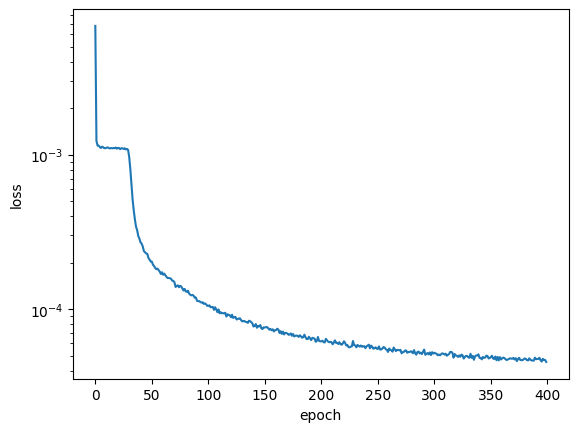

In [7]:
plt.plot(a)
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')